In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

from marked_hawkes import kernel_fct, lambda_rate, fit_parameters, get_total_events

We will start with visualizing how would kernel function for an event with mark 1000 evolve, where it's parameters are $\kappa = 0.8$, $\beta = 0.6$, $c = 10$ and $\theta = 0.8$.

### Plotting Memory function for the Social Kernel 

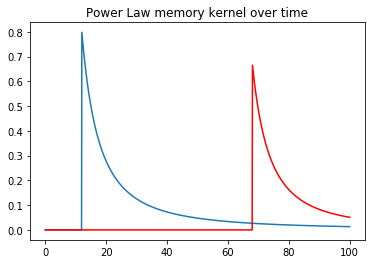

In [5]:
# initial event we want to use for simmulation (magnitude, time)
event1, event2 = [1000, 12], [750, 68]
# series of time points we want to simmulate event for
t = np.linspace(0, 100, 1000)

# Power Law Kernel
# calling the kernelfunction to get the values
pl_values1 = kernel_fct(event=event1, t=t)
pl_values2 = kernel_fct(event=event2, t=t)

plt.plot(t, pl_values1)
plt.plot(t, pl_values2, 'r')

plt.title("Power Law memory kernel over time");

In this section, we first read a real twitter cascade and then fit a hawkes model to it after observing first 1 hour of cacscade and then we will do the final prediction. A retweet cascade is provided in the file 'example.csv' with each row representing an event with values of the form  

** [magnitude(#user followers), time(secs)] **

In [7]:
# read the real cascade provided in the file example.csv
real_cascade = pd.read_csv('example_book.csv', names=['magnitude', 'time'], header=0)
real_cascade.index -= 1
real_cascade.head(10)

,magnitude,time
0,40989,0
1,1445,21
2,563,31
3,329,33
4,555,49
5,513,54
6,28145,58
7,100,62
8,164,82
9,491,87


In [24]:
observation_duration = 600 # seconds
history = real_cascade[real_cascade['time']<=observation_duration]

params1 = dict(K=0.24, 
              beta=0.5, 
              c=2, 
              theta=0.2)
params2 = dict(K=0.8, beta=0.6, c=10., theta=0.8)

**Event rate $\lambda(t)$ vizualisation**

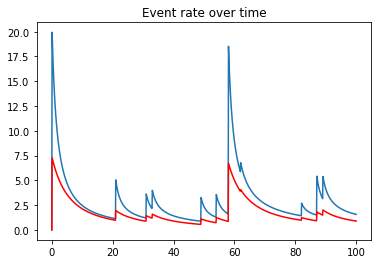

In [25]:
event_rate1 = lambda_rate(t, history.to_numpy(), params1)
event_rate2 = lambda_rate(t, history.to_numpy(), params2)

plt.plot(t, event_rate1)
plt.plot(t, event_rate2, 'r')
plt.title("Event rate over time");

**Testing the fit_params function**

In [27]:
start_params = np.array([1, 1, 250, 1])
result_params, result_info = fit_parameters(history.to_numpy(), start_params)
print("Values of fitted parameters:")
print(f"K: {result_params[0]}")
print(f"beta: {result_params[1]}")
print(f"c: {result_params[2]}")
print(f"theta: {result_params[3]}")


Objective value at iteration #0 is - 297.971
Values of fitted parameters:
K: 0.9999999932687489
beta: 1.0154926541446767
c: 250.65753068933984
theta: 1.3381078463559715


In [ ]:
start_params = np.array([0.8, 0.6, 100, 0.7])
result_params, result_info = fit_parameters(history.to_numpy(), start_params)
print("Values of fitted parameters:")
print(f"K: {result_params[0]}")
print(f"beta: {result_params[1]}")
print(f"c: {result_params[2]}")
print(f"theta: {result_params[3]}")

fitted_params = dict(K=result_params[0],beta=result_params[1],c=result_params[2],theta=result_params[3])

Objective value at iteration #0 is - 166.951


/home/quentin/Documents/PFE-SD9/protoprojetsd9/hawkes_point_process/marked_hawkes.py:180: RuntimeWarning: invalid value encountered in log
  np.log(theta) - (theta * np.log(c))


Objective value at iteration #100 is - 149.05
Objective value at iteration #200 is - 147.999


### Modeling a retweet cascade with marked Hawkes Process

Now we plot part of the observed event series and the corresponding intensity function with fitted parameters. We do not plot the whole observed parts as it's too big to be seen with useful information on a single small graph


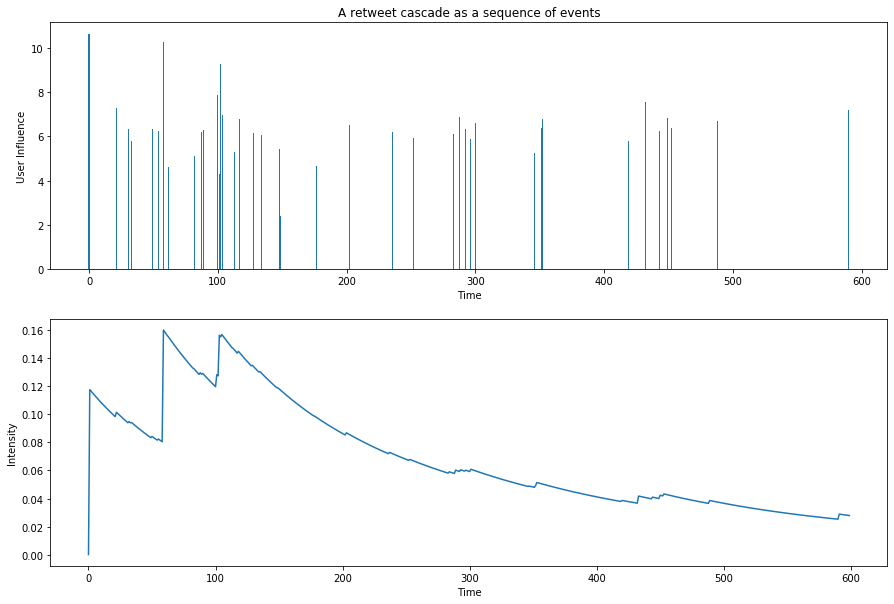

In [50]:
plt_time = 600
plt_data = history[history['time']<=plt_time]
intensity = lambda_rate(t=np.arange(0, plt_time, 1), history=history.to_numpy(),
                        params=dict(K=fitted_params['K'], beta=fitted_params['beta'], 
                                    c=fitted_params['c'], theta=fitted_params['theta']))

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.bar(plt_data['time'].values, np.log(plt_data['magnitude'].values), linewidth=5)
plt.title('A retweet cascade as a sequence of events')
plt.xlabel('Time')
plt.ylabel('User Influence')

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, plt_time, 1), intensity)
plt.xlabel('Time')
plt.ylabel('Intensity');

### Using the model to make predictions of final size

In [53]:
# To get predictions from fitted model we can call the function that estimates the final number of tweets
# in the cascade
prediction = get_total_events(history=history.to_numpy(), T=observation_duration,
                              params=fitted_params)
print(prediction)

{'total': 216.0, 'n_star': 0.9222946426162629, 'a1': 13.413424255591291}


In [56]:
# Total length of real casacde
n_real = len(real_cascade)
n_pred = prediction['total']
print(f"The real size of cascade is {n_real} and predicted values is {int(n_pred)}")
print(f"The relative error in percentage is {round(100 * abs(n_real - n_pred) / n_real, 2)}")

The real size of cascade is 219 and predicted values is 216
The relative error in percentage is 1.37
